# Attractor municipalities

In this script we select the attractor municipalitites based on the complexity index.

We cluster the data using in one axis the complexity of the X municiaplity and in the other the number of municipalitites that have a complexity index at 1/2 standard deviations from the complexity index of the X municipality.

We make 7 clusters and select the municipalities that fall in the last part of the distribution.

The output of this script is a csv file with the attractors.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon

from descartes import PolygonPatch

import pyproj
import json
from shapely.geometry import Point, mapping
from functools import partial
from shapely.ops import transform


# Paths and names

In [2]:
# We define the paths and names for the input files

# this is allison's path
# entities_path = 'marco_geoestadistico_2018/'

# this is jerry's path
entities_path = 'data/marco_geoestadistico_2018/'


# complexity_path = 'ECI_2014__municipal_A111A_H001A_6.csv'

# We define the paths and names for the output files

In [3]:
# We define a dictionary to read the shape files
entities= {
    '01' :['01Ags','01_aguascalientes'],
    '02' :['02BC','02_bajacalifornia'],
    '03' :['03BCS','03_bajacaliforniasur'],
    '04' :['04Camp', '04_campeche'],
    '05' :['05Coah','05_coahuiladezaragoza'],
    '06' :['06Col','06_colima'],
    '07' :[ '07Chs','07_chiapas'],
    '08' :['08Chih','08_chihuahua'],
    '09' :['09CdMx','09_ciudaddemexico'],
    '10' :['10Dur','10_durango'],
    '11' :['11Gto', '11_guanajuato'],
    '12' :['12Gro','12_guerrero'],
    '13' :['13Hgo','13_hidalgo'],
    '14' :['14Jal','14_jalisco'],
    '15' :['15EdoMex','15_mexico'],
    '16' :['16Mich','16_michoacandeocampo'],
    '17' :['17Mor','17_morelos'],
    '18' :['18Nay','18_nayarit'],
    '19' :['19NL', '19_nuevoleon'],
    '20' :['20Oax', '20_oaxaca'],
    '21' :['21Pue', '21_puebla'],
    '22' :['22Qro','22_queretaro'],
    '23' :['23QRoo','23_quintanaroo'], 
    '24' :['24SLP','24_sanluispotosi'],
    '25' :['25Sin','25_sinaloa'],
    '26' :['26Son','26_sonora'],
    '27' :['27Tab','27_tabasco'],
    '28' :['28Tamps','28_tamaulipas'],
    '29' :['29Tlax','29_tlaxcala'],
    '30' :['30Ver','30_veracruzignaciodelallave'],
    '31' :[ '31Yuc','31_yucatan'],
    '32' :[ '32Zac','32_zacatecas']

    
}

In [4]:


# complexity = pd.read_csv('/home/lorena/Documents/Economia/clusterizacion_y_complejidad/Data/Municipality/Produccion_bruta_sobre_empleo/'+complexity_path)

# complexity['clave_entidad'] = complexity.clave_entidad.apply(lambda l:str(l).zfill(5))
# print("complexity data: ",complexity.shape)
# complexity.head(1)

# Entities shapefiles

In [5]:
urban_shapes = []

for i in range(1,33):
    a = str(i).zfill(2)
    
    urban_agebs = gpd.read_file(entities_path + entities[a][1]+'/conjunto de datos/'+entities[a][1][0:2]+'mun'+'.shp')
    
    urban_shapes.append(urban_agebs)
    print(a, urban_agebs.shape)
    
    
urban_shapes = pd.concat(urban_shapes)

display(urban_shapes.head(1))

01 (11, 5)
02 (5, 5)
03 (5, 5)
04 (11, 5)
05 (38, 5)
06 (10, 5)
07 (123, 5)
08 (67, 5)
09 (16, 5)
10 (39, 5)
11 (46, 5)
12 (81, 5)
13 (84, 5)
14 (125, 5)
15 (125, 5)
16 (113, 5)
17 (33, 5)
18 (20, 5)
19 (51, 5)
20 (570, 5)
21 (217, 5)
22 (18, 5)
23 (11, 5)
24 (58, 5)
25 (18, 5)
26 (72, 5)
27 (17, 5)
28 (43, 5)
29 (60, 5)
30 (212, 5)
31 (106, 5)
32 (58, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774..."


In [6]:
gs = gpd.GeoSeries(urban_shapes['geometry'])

In [7]:
gs.crs = {'init' :'epsg:4326'}

In [8]:
area = gs.area

In [9]:
urban_shapes['area'] = area

In [10]:
urban_shapes = urban_shapes.to_crs({'init' :'epsg:4326'})

centroid = urban_shapes.centroid

urban_shapes['centroid'] = centroid

In [11]:
urban_shapes

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area,centroid
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",1.166359e+09,POINT (-102.29580 21.81144)
1,01002,01,002,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",5.433743e+08,POINT (-102.04564 22.12651)
2,01003,01,003,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0...",9.233578e+08,POINT (-102.70490 21.90069)
3,01004,01,004,CosÃ­o,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",1.283835e+08,POINT (-102.29704 22.36063)
4,01005,01,005,JesÃºs MarÃ­a,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",4.998951e+08,POINT (-102.44565 21.93212)
...,...,...,...,...,...,...,...
53,32054,32,054,Villa Hidalgo,"POLYGON ((-101.69490 22.51777, -101.69472 22.5...",3.714260e+08,POINT (-101.71432 22.40736)
54,32055,32,055,Villanueva,"POLYGON ((-102.78252 22.67373, -102.78221 22.6...",2.156506e+09,POINT (-102.85151 22.29827)
55,32056,32,056,Zacatecas,"POLYGON ((-102.53955 22.77820, -102.53954 22.7...",4.367857e+08,POINT (-102.67808 22.73573)
56,32057,32,057,Trancoso,"POLYGON ((-102.22547 22.80920, -102.22946 22.7...",2.184470e+08,POINT (-102.31200 22.75563)


In [12]:
anchors = pd.read_csv('complejidad_alta.csv')

In [13]:
anchors

,cve_mun,NOMGEO
0,14039,Guadalajara
1,9016,Miguel Hidalgo
2,19039,Monterrey
3,9015,Cuauhtémoc
4,24028,San Luis Potosí
...,...,...
132,5025,Piedras Negras
133,7078,San Cristóbal de las Casas
134,21140,San Pedro Cholula
135,29005,Apizaco


In [14]:
for i in range(0,137):
    anchors['cve_mun'].iloc[i] = str(anchors['cve_mun'].iloc[i]).zfill(5)

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
anchors_shapes = urban_shapes.loc[urban_shapes['CVEGEO'].isin(anchors['cve_mun'])]

In [16]:
anchors_shapes['area'].describe()

count    1.370000e+02
mean     1.960480e+09
std      5.306802e+09
min      2.296278e+07
25%      1.133226e+08
50%      4.732433e+08
75%      1.447677e+09
max      5.323784e+10
Name: area, dtype: float64

In [17]:
min_area = anchors_shapes['area'].min()

In [18]:
radius = []
for i in range(0,137):
    area = anchors_shapes['area'].iloc[i]
    radius.append(50*(math.log(area/min_area,10) + 1))

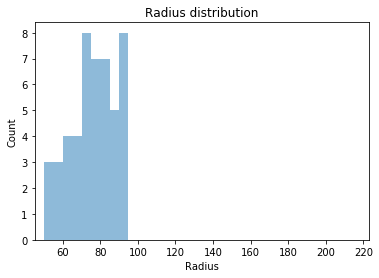

In [19]:
bins = np.arange(-100, 100, 5) # fixed bin size

plt.xlim([min(radius)-5, max(radius)+5])

plt.hist(radius, bins=bins, alpha=0.5)
plt.title('Radius distribution')
plt.xlabel('Radius')
plt.ylabel('Count')

plt.show()

In [20]:
gs_anchors = gpd.GeoSeries(anchors_shapes['geometry'])

gs_anchors.crs = {'init' :'epsg:4326'}
area_anchors = gs_anchors.area
anchors_shapes['area'] = area_anchors

anchors_shapes['radius'] = radius

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
import math

polygon_list = []
    
def find_circle(point, radius_individual):

    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )
    
    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(radius_individual*1000)

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)

    return (Polygon(buffer_wgs84))


In [22]:
for i in range(anchors_shapes.shape[0]):
    
    polygon_list.append(find_circle(anchors_shapes['centroid'].iloc[i],anchors_shapes['radius'].iloc[i]))


In [23]:
anchors_shapes['circlerange'] = polygon_list

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
dummy = urban_shapes

In [25]:
for t in range(anchors_shapes.shape[0]):
    one_column = []
    
    check_polygon = anchors_shapes['circlerange'].iloc[t]
    
    for i in range(urban_shapes.shape[0]):
        
        check_point = (urban_shapes['centroid'].iloc[i])
        
        if urban_shapes['CVEGEO'].iloc[i] in anchors['cve_mun'].unique():
            dummy_value = 2 * (check_polygon.contains(check_point))
        else:
            dummy_value = 1 * (check_polygon.contains(check_point))
        
        one_column.append(dummy_value)
    
    temp_str = "attr"+str(t)
    
    dummy[temp_str] = one_column

dummy

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area,centroid,attr0,attr1,attr2,...,attr127,attr128,attr129,attr130,attr131,attr132,attr133,attr134,attr135,attr136
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",1.166359e+09,POINT (-102.29580 21.81144),2,2,0,...,0,0,0,0,0,0,0,0,2,2
1,01002,01,002,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",5.433743e+08,POINT (-102.04564 22.12651),1,1,0,...,0,0,0,0,0,0,0,1,1,1
2,01003,01,003,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0...",9.233578e+08,POINT (-102.70490 21.90069),1,1,0,...,0,0,0,0,0,0,0,1,1,1
3,01004,01,004,CosÃ­o,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",1.283835e+08,POINT (-102.29704 22.36063),1,1,0,...,0,0,0,0,0,0,0,1,1,1
4,01005,01,005,JesÃºs MarÃ­a,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",4.998951e+08,POINT (-102.44565 21.93212),2,2,0,...,0,0,0,0,0,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,32054,32,054,Villa Hidalgo,"POLYGON ((-101.69490 22.51777, -101.69472 22.5...",3.714260e+08,POINT (-101.71432 22.40736),1,1,0,...,0,0,0,0,0,0,0,1,1,1
54,32055,32,055,Villanueva,"POLYGON ((-102.78252 22.67373, -102.78221 22.6...",2.156506e+09,POINT (-102.85151 22.29827),1,1,0,...,0,0,0,0,0,0,0,1,1,1
55,32056,32,056,Zacatecas,"POLYGON ((-102.53955 22.77820, -102.53954 22.7...",4.367857e+08,POINT (-102.67808 22.73573),2,2,0,...,0,0,0,0,0,0,0,2,2,2
56,32057,32,057,Trancoso,"POLYGON ((-102.22547 22.80920, -102.22946 22.7...",2.184470e+08,POINT (-102.31200 22.75563),1,1,0,...,0,0,0,0,0,0,0,1,1,1


In [26]:
anchor_overlap = dummy.loc[dummy['CVEGEO'].isin(anchors['cve_mun'])]

In [27]:
# dummy.to_csv('phase_1.csv')

# Below is the visualization part

In [28]:
anchor_overlap['radius'] = radius

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
anchor_overlap

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area,centroid,attr0,attr1,attr2,...,attr128,attr129,attr130,attr131,attr132,attr133,attr134,attr135,attr136,radius
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",1.166359e+09,POINT (-102.29580 21.81144),2,2,0,...,0,0,0,0,0,0,0,2,2,135.290389
4,01005,01,005,JesÃºs MarÃ­a,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",4.998951e+08,POINT (-102.44565 21.93212),2,2,0,...,0,0,0,0,0,0,2,2,2,116.892716
0,02002,02,002,Mexicali,"MULTIPOLYGON (((-112.89233 28.67826, -112.8919...",1.579446e+10,POINT (-115.16623 31.74174),0,0,2,...,0,0,0,0,0,0,0,0,0,191.874008
2,02004,02,004,Tijuana,"MULTIPOLYGON (((-117.24565 32.41390, -117.2456...",1.252511e+09,POINT (-116.81997 32.40407),0,0,2,...,0,0,0,0,0,0,0,0,0,136.837854
4,02001,02,001,Ensenada,"MULTIPOLYGON (((-115.86632 32.26877, -115.8651...",5.323784e+10,POINT (-114.95721 30.03651),0,0,2,...,0,0,0,0,0,0,0,0,0,218.259794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,30193,30,193,Veracruz,"MULTIPOLYGON (((-96.09229 19.17375, -96.09240 ...",2.458809e+08,POINT (-96.22166 19.18583),0,0,0,...,2,0,0,0,2,0,0,0,0,101.485012
49,31050,31,050,MÃ©rida,"POLYGON ((-89.55766 20.97731, -89.55744 20.977...",8.755765e+08,POINT (-89.63952 20.98407),0,0,0,...,0,0,0,0,0,2,0,0,0,129.063478
9,32010,32,010,Fresnillo,"POLYGON ((-102.90780 23.57451, -102.90600 23.5...",5.037308e+09,POINT (-102.99594 23.23683),0,0,0,...,0,0,0,0,0,0,2,2,2,167.058697
16,32017,32,017,Guadalupe,"POLYGON ((-102.54026 22.77550, -102.54022 22.7...",8.083220e+08,POINT (-102.40763 22.78020),2,2,0,...,0,0,0,0,0,0,2,2,2,127.327993


In [30]:
anchor_overlap.index = range(0, 137) 

print ('the index number which has the max radius', anchor_overlap['radius'].argmax())
print ('the index number which has the min radius', anchor_overlap['radius'].argmin())

4
28


/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  after removing the cwd from sys.path.


In [31]:
def find_circle_2(point, radius_individual):
    global polygon_list
    
    # inputs
    radius = 1000 * radius_individual # m - the following code is an approximation that stays reasonably accurate for distances < 100km
    centerLat = point.x # latitude of circle center, decimal degrees
    centerLon = point.y # Longitude of circle center, decimal degrees

    # parameters
    N = 1000 # number of discrete sample points to be generated along the circle

    # generate points
    circlePoints = []
    for k in range(N):
        # compute
        angle = math.pi*2*k/N
        dx = radius*math.cos(angle)
        dy = radius*math.sin(angle)

        point = ((centerLat + (180/math.pi)*(dy/6378137)), centerLon + (180/math.pi)*(dx/6378137)/math.cos(centerLat*math.pi/180))
        
        circlePoints.append(point)
        
    return(Polygon(circlePoints))

    

anchor_overlap_2 = pd.DataFrame(data=[['max',4, find_circle_2(anchor_overlap['centroid'].iloc[4], anchor_overlap['radius'].iloc[4]), anchor_overlap['centroid'].iloc[4], anchor_overlap['radius'].iloc[4]], 
                                         ['min',28, find_circle_2(anchor_overlap['centroid'].iloc[28], anchor_overlap['radius'].iloc[28]), anchor_overlap['centroid'].iloc[28], anchor_overlap['radius'].iloc[28]]],
                               
                                columns = ['name', 'index_nu', 'geometry','centroid', 'radius'])
                                
                                         
anchor_overlap_2


,name,index_nu,geometry,centroid,radius
0,max,4,POLYGON ((-114.9572143003527 25.38974749343996...,POINT (-114.9572143003527 30.03650954819659),218.259794
1,min,28,POLYGON ((-99.09432979681166 16.55522739640958...,POINT (-99.09432979681166 19.39691189712158),50.000000


No handles with labels found to put in legend.


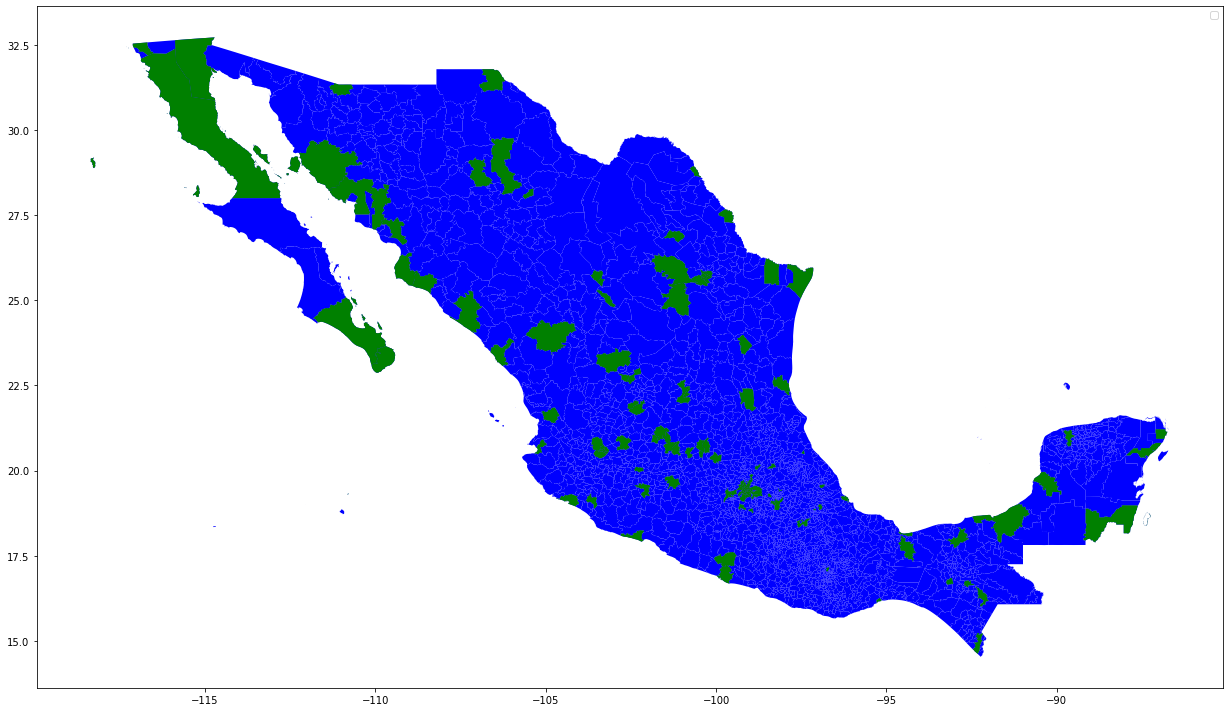

In [38]:
fig, ax = plt.subplots(figsize=(20,10))

(urban_shapes).plot(ax=ax, color='blue', label='non-attractor');

(anchor_overlap).plot(ax=ax, color='green', label='attractor');

plt.legend()

plt.tight_layout();
    

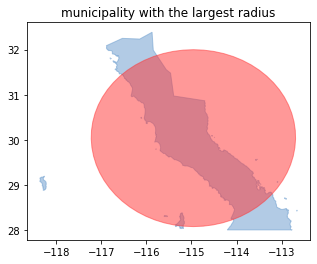

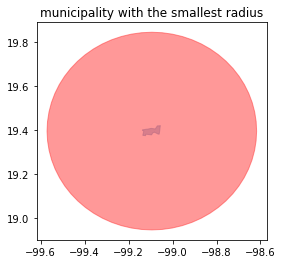

In [36]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch

BLUE = '#6699cc'
RED = '#ff3333'

fig = plt.figure() 
ax = fig.gca() 

ax.add_patch(PolygonPatch(anchor_overlap['geometry'].iloc[4], fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.add_patch(PolygonPatch(find_circle(anchor_overlap_2['centroid'][0], anchor_overlap_2['radius'][0]), fc=RED, ec=RED, alpha=0.5, zorder=2 ))

ax.axis('scaled')
plt.title('municipality with the largest radius')
plt.show()



fig = plt.figure() 
ax = fig.gca() 

ax.add_patch(PolygonPatch(anchor_overlap['geometry'].iloc[28], fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.add_patch(PolygonPatch(find_circle(anchor_overlap_2['centroid'][1], anchor_overlap_2['radius'][1]), fc=RED, ec=RED, alpha=0.5, zorder=2 ))

ax.axis('scaled')
plt.title('municipality with the smallest radius')
plt.show()

# Merge shapes y complejidad

In [34]:
# We rename the columns in the shapefiles and drop the columns we don't need 
urban_shapes = urban_shapes.rename(columns={'CVEGEO':'clave_entidad'})
del urban_shapes['CVE_ENT']
del urban_shapes['CVE_MUN']

print("Shapefile: ",urban_shapes.shape)
urban_shapes.head(1)

# We merge the polygons of the entities with the complexity index for each entity
mexico = urban_shapes.merge(complexity, on='clave_entidad' , how='outer')

# There are a few municipalities for which we don't have the complexity index because they're new in the country
# we take those out, they're 7
mexico = mexico[~mexico.ECI.isnull()]
mexico.plot()


Shapefile:  (2463, 142)


NameError: name 'complexity' is not defined

# Selección de focos atractores

In [ ]:
# Desviación estándar de los datos de complejidad
sd = np.std(mexico.ECI.values.tolist())

# Le asignamos a cada municipio el número de municipios cuya complejidad cae a +/- 1/2 de desviación estándar 
# de su complejidad.

final = []
for i in range(len(mexico.ECI.values.tolist())):
    
    d = mexico.ECI.values.tolist()[i]
    m = mexico.cve_mun.values.tolist()[i]
    
    mas_sd = d + (sd/2)
    menos_sd = d - (sd/2)
   
    cluster = 0
    for j in mexico.ECI.values.tolist():
        if j > menos_sd and j < mas_sd:
            cluster = cluster +1
           
            
    a = (m,d, cluster)
    
    final.append(a)
   

df = pd.DataFrame(final)
df = df.rename(columns={1:'ECI',2:'normalidad',0:'cve_mun'})
df = df.sort_values(by='ECI', ascending=False)

# Normalizamos los datos de complejidad y "normalidad" para clusterizar
df['ECI_norm'] = (df['ECI'] -df['ECI'].min()) / (df['ECI'].max()- df['ECI'].min())
df['normalidad_norm'] = (df['normalidad'] - df['normalidad'].min()) / (df['normalidad'].max()-df['normalidad'].min())

#### Usamos los datos de complejidad y "normalidad" normalizados para clusterizar al país

In [ ]:
X = df[['ECI_norm','normalidad_norm']].values

# Dividimos al país en 7 clusters
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

df['cluster'] = kmeans.labels_.tolist()

plt.figure(figsize=(15,15))
for i in range(0,7):
    sub = df[df.cluster == i]
    
    plt.scatter(x=sub['ECI'], y=sub['normalidad'])
   
    print(i, sub['ECI'].max(), sub['ECI'].min(), sub['normalidad'].max(), sub['normalidad'].min(), sub.shape[0])
    

In [ ]:
maximos = df[df.cluster == 5][['cve_mun']]

In [ ]:
nombres = urban_shapes[['NOMGEO', 'cve_mun']]

In [ ]:
maximos = maximos.merge(nombres, on='cve_mun', how='left')

In [ ]:
maximos.to_csv('complejidad_alta.csv',index=False, encoding='latin')

In [ ]:
maximos

In [ ]:
#complejidad.tail(50).to_csv('municipios_menos_complejos.csv', index=False, )

# Proximidad con Aeroespacial

In [ ]:
acts= [311511,541930,336410,711320,541820,561590,336340,339992,335920,
339991,327213,236212,623221,331220,311940,331210,335920,431193,711320,
541930,519110,333242,333412,331220,339113,334519,541370,339113,'6232CC',
541870,493120,336610,623221,312131]


In [ ]:
for i in range(len(acts)):
    acts[i] = str(acts[i])

In [ ]:
relate = pd.read_csv('/home/lorena/Documents/Economia/clusterizacion_y_complejidad/Data/Municipality/Produccion_bruta_sobre_empleo/relatedness_matrix_clave_actividad_economica_and_cve_mun_2014_A111A_H001A_6.csv')
print(relate.shape)
display(relate.head())

In [ ]:
relate = relate[relate.clave_actividad.isin(acts)]

In [ ]:
aero = []
peso = []
for mun in relate.set_index('clave_actividad').columns:
    print(mun)
    #m = 0
    for value in relate[mun].values:
        m=0
        if value > 0.2:
            m = m +1


    if m != 0:
        aero.append(str(mun).zfill(5))
        peso.append(m)
    #break

In [ ]:
data= pd.DataFrame({'clave_entidad':aero, 'peso':peso})
print(data.shape)

In [ ]:
data['peso'] = data['peso']  / data['peso'].max() + 1

In [ ]:
data.max()

In [ ]:
urban_shapes_1 = urban_shapes.merge(data, on='clave_entidad', how='left')
urban_shapes_1.loc[urban_shapes_1.peso.isnull(),'peso'] = 0.5

In [ ]:
urban_shapes_1['peso'] = (urban_shapes_1['peso'] - urban_shapes_1['peso'].min()) / (urban_shapes_1['peso'].max() - urban_shapes_1['peso'].min())

In [ ]:
urban_shapes_1.plot(figsize=(15,15),column='peso', cmap = 'Greens', vmax=2, vmin=0)

In [ ]:
x = urban_shapes_1[urban_shapes_1.peso != 0.5][['clave_entidad','NOMGEO','peso']]
x.to_csv('municipios_aeroespacial.csv',index=False, encoding='latin')